### Short- and long-wave radiation inside canopies
### pyAPES.microclimate.radiation

- absorption, transmittance and scattering of short-wave (SW) radiation at PAR and NIR -wavebands
- horizontally homogeneous porous media with vertically varying leaf-area density $\Lambda_{z}$ [m2 m-3] profile
- emission, absorption and transmittance of long-wave (LW) thermal radiation

STATUS (20.1.2025 / Samuli):

- add how to initialize and run *microclimate.radiation.Radiation* instance
- long-wave emission and transfer, include into demo of *pyAPES.canopy.mlm_canopy*

In [1]:
# setting path
import sys
#sys.path.append('c:\\Repositories\\pyAPES_main')
import os
from dotenv import load_dotenv

load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')

sys.path.append(pyAPES_main_folder)
#print(sys.path)

# imports
import numpy as np
import matplotlib.pyplot as plt

# force iPython re-import modules at each call
%load_ext autoreload
%autoreload 2

### pyAPES.microclimate.radiation
- Class *Radiation*, sub-model for computing SW and LW transfer in multi-layer canopies. Called from *pyAPES.canopy.mlm_canopy.CanopyModel.run()*

- SW radiation with two alternative schemes: 
    - *radiation.canopy_sw_ZhaoQualls()* with explicit treatment of multiple scattering (Zhao & Qualls, 2006a)
    - *radiation.canopy_sw_spitters()* with implicit analytical approximation of multiple scattering (Spitters et al. 1986), ok particularly for PAR
    - provide profiles of incident direct beam, diffuse and upward-diffuse radiation, as well as absorbed PAR and NIR per unit sunlit & shaded leaf area at each canopy layer for computing leaf energy balance & gas-exchange.  Sunlit fraction of foliage computed from beam extinction.

- LW radiation with two schemes:
    - *radiation.canopy_lw_ZhaoQualls()* with multiple scattering (Zhao & Qualls, 2006b)
    - *radiation.canopy_lw()*; simpler scheme neglecting scattering (modified from Flerchinger et al. 2009)

- solar zenith, azimuth and declination angles, sunrise, sunset times and daylength from lat, lon and time:
    - *radiation.solar_angles()*

- beam and diffuse extinction coefficients (Campbell & Norman, 1998) 
    - *radiation.kbeam()*
    - *radiation.kdiffuse()*

- cloud fraction, diffuse fraction and atmospheric emissivity estimated from surface observations; reasonable at least for Finland
    - *radiation.compute_clouds_rad()*


In [2]:
# import Radiation Class
from pyAPES.microclimate.radiation import Radiation

# import functions
from pyAPES.microclimate.radiation import canopy_sw_ZhaoQualls, canopy_sw_Spitters, canopy_lw_ZhaoQualls, solar_angles, kbeam, kdiffuse

# conversion factors
from pyAPES.utils.constants import DEG_TO_RAD, DEG_TO_KELVIN, PAR_TO_UMOL

# forcing
from pyAPES.utils.iotools import read_forcing

FORC = read_forcing('c:/Repositories/pyAPES_main/forcing/FIHy_forcing_2006_2008.dat', 
                    start_time='2006-01-01', end_time='2007-01-01')

# pandas
import pandas as pd

### Solar angles  

(array([13300.  , 13300.25, 13300.5 , 13300.75, 13301.  , 13301.25,
        13301.5 , 13301.75, 13302.  ]),
 [Text(13300.0, 0, '06-01 00'),
  Text(13300.25, 0, '06-01 06'),
  Text(13300.5, 0, '06-01 12'),
  Text(13300.75, 0, '06-01 18'),
  Text(13301.0, 0, '06-02 00'),
  Text(13301.25, 0, '06-02 06'),
  Text(13301.5, 0, '06-02 12'),
  Text(13301.75, 0, '06-02 18'),
  Text(13302.0, 0, '06-03 00')])

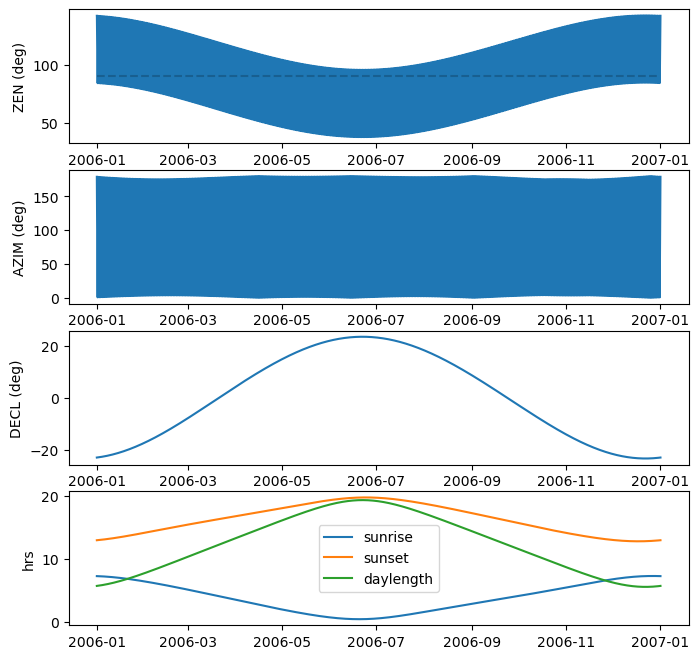

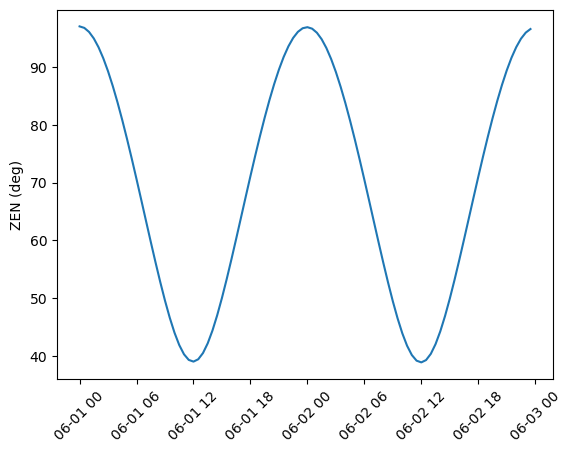

In [3]:
ttime = FORC.index

decimalday = ttime.dayofyear + ttime.hour / 24 + ttime.minute / (24*60)

lat = 61.0 # deg
lon = 30.0 # deg
timezone = +2.0

zen, azim, decl, sunrise, sunset, daylength = solar_angles(lat, lon, decimalday, timezone)

fig, ax = plt.subplots(4,1, figsize=(8,8))

ax[0].plot(ttime, zen / DEG_TO_RAD, '-'); 
ax[0].plot([ttime[0], ttime[-1]], [90., 90.], 'k--', alpha=0.2)
ax[0].set_ylabel('ZEN (deg)')

ax[1].plot(ttime, azim / DEG_TO_RAD, '-'); 
ax[1].set_ylabel('AZIM (deg)')

ax[2].plot(ttime, decl / DEG_TO_RAD, '-'); 
ax[2].set_ylabel('DECL (deg)')

ax[3].plot(ttime, sunrise / 60, '-', label='sunrise')
ax[3].plot(ttime, sunset / 60, '-', label='sunset')
ax[3].plot(ttime, daylength / 60, '-', label='daylength')
ax[3].legend()
ax[3].set_ylabel('hrs')

# zoom in for short period
fig, ax = plt.subplots(1,1)
ix = (ttime >='2006-06-01') & (ttime < '2006-06-03')
ax.plot(ttime[ix], zen[ix] / DEG_TO_RAD)
ax.set_ylabel('ZEN (deg)')
plt.xticks(rotation=45.)


### Create simple canopy with uniform leaf-area density, and compute radiation profiles for single time step.

In [4]:
# create stand with uniform leaf-area density

# stand 1-sided leaf-area index [m2 m-2]
LAI = 3.0
nlyrs = 30 # layers

# allocate LAI uniformly between nodes 1 and -1 (radiation models require at least one node with lad[i]=0.0 above canopy top)
laiz = np.zeros(nlyrs)
laiz[1:-1] = LAI / (nlyrs-2)

# optical parameters
p = {'clump': 0.7,  # clumping index [-]
     'leaf_angle': 1.0,  # leaf-angle distribution [-]
     'Par_alb': 0.12,  # shoot Par-albedo [-]
     'Nir_alb': 0.55,  # shoot NIR-albedo [-]
     'leaf_emi': 0.98,  # leaf emissivity [-]
     'x': 1.0 # leaf-angle distribution parameter (1.0 == spherical)
    }

# dict to store results

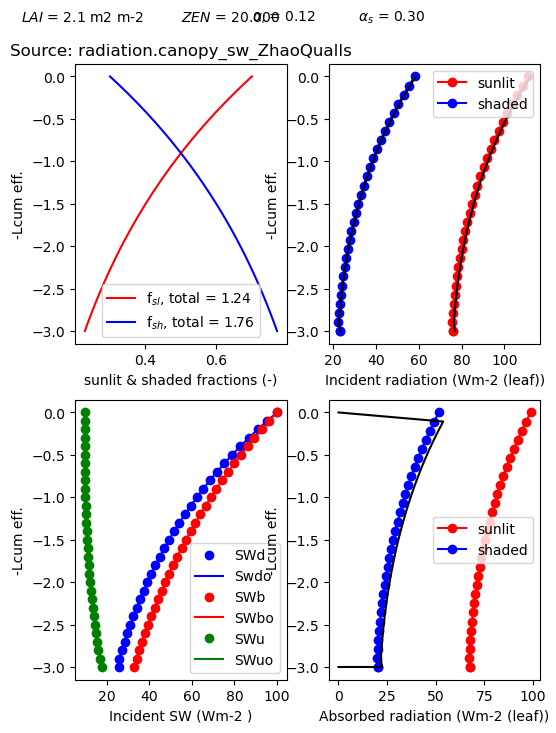

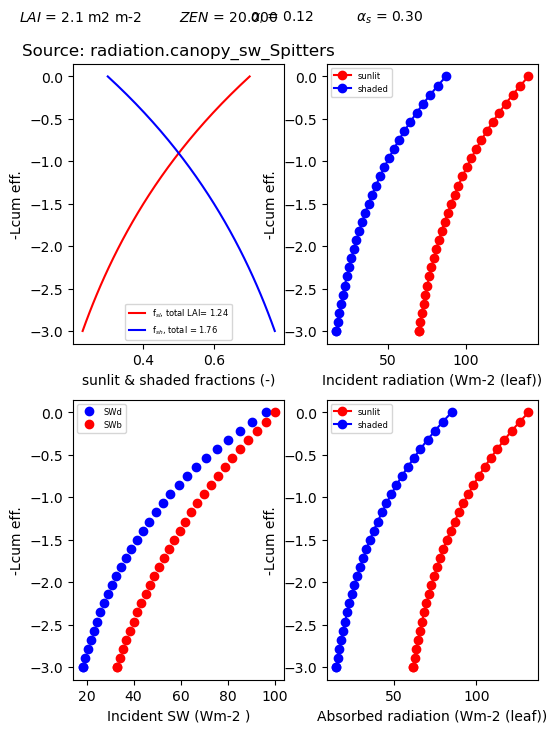

In [13]:
# compute vertical PAR profiles for ZEN = 20.0 deg
zen = 20.0 * DEG_TO_RAD

# the units are arbitrary here
rdir = 100.0
rdiff = 100.0

# call functions
SWb, SWd, SWu, Q_sl, Q_sh, q_sl, q_sh, q_soil, f_sl, alb = canopy_sw_ZhaoQualls(LAIz=laiz, Clump=0.7, x=1.0, Zen=zen, 
                                                                                    IbSky=rdir, IdSky=rdiff, 
                                                                                    LeafAlbedo=0.12, SoilAlbedo=0.3, PlotFigs=True)

SWb, SWd, Q_sl, Q_sh, q_sl, q_sh, q_soil, f_sl, alb = canopy_sw_Spitters(LAIz=laiz, Clump=0.7, x=1.0, Zen=zen, 
                                                                                    IbSky=rdir, IdSky=rdiff, 
                                                                                    LeafAlbedo=0.12, SoilAlbedo=0.3, PlotFigs=True)